In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
import tensorflow as tf

# Basic RNNs

## Manual RNNs

In [17]:
n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X0, Wx) + b)

init = tf.global_variables_initializer()

In [18]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [19]:
print(Y0_val)

[[ 0.99992317  0.26868555 -0.948313    0.31842172  0.8182412 ]
 [ 0.99999964 -0.8755575  -0.99998957  0.57613033 -0.26623812]
 [ 1.         -0.9949376  -1.          0.7545392  -0.9350447 ]
 [-1.         -1.         -0.9888929  -0.9999035  -1.        ]]


In [20]:
print(Y1_val)

[[ 0.99903595  0.99996454 -0.9723586   0.45936838  0.9749111 ]
 [ 1.          0.7811401  -0.9999658  -0.7269998   0.72139037]
 [ 1.         -0.9763916  -1.         -0.87175256 -0.2756679 ]
 [-1.         -1.         -0.6013782  -0.9998596  -1.        ]]


## Using static_rnn()

In [21]:
X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units = n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)
Y0, Y1 = output_seqs

In [22]:
init = tf.global_variables_initializer()

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [23]:
print(Y0_val)

[[-0.8173852   0.57456183 -0.676111    0.3911744   0.5261633 ]
 [-0.9604466   0.9942087  -0.98300654 -0.7531797   0.9245188 ]
 [-0.9919306   0.9999376  -0.9992401  -0.9828011   0.99013966]
 [ 0.999941    0.9688596   0.00511692 -0.9992603   0.9990845 ]]


In [24]:
print(Y1_val)

[[-0.8049607   0.9999832  -0.99876034 -0.99987626  0.9297197 ]
 [ 0.23336807  0.23327753 -0.3687077   0.0880859  -0.5899081 ]
 [-0.17664646  0.9995557  -0.9928473  -0.9953009   0.7264017 ]
 [ 0.0176558   0.9870066  -0.2082494  -0.98234487  0.39359325]]


In [25]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [26]:
show_graph(tf.get_default_graph())

## Using packing sequence

In [29]:
n_steps =2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [30]:
init = tf.global_variables_initializer()

In [31]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    output_val = outputs.eval(feed_dict={X: X_batch})

In [33]:
print(output_val)

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.9428799  -0.9998869   0.94055814  0.9999985  -0.9999997 ]]

 [[-0.8001535  -0.9921827   0.7817797   0.9971032  -0.9964609 ]
  [-0.637116    0.11300927  0.5798437   0.4310559  -0.6371699 ]]

 [[-0.93605185 -0.9998379   0.9308867   0.9999815  -0.99998295]
  [-0.9165386  -0.9945604   0.896054    0.99987197 -0.9999751 ]]

 [[ 0.9927369  -0.9981933  -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746338 -0.73191994  0.7827872   0.9525682  -0.9781773 ]]]


In [35]:
print(np.transpose(output_val, axes=[1, 0, 2])[1])

[[-0.9428799  -0.9998869   0.94055814  0.9999985  -0.9999997 ]
 [-0.637116    0.11300927  0.5798437   0.4310559  -0.6371699 ]
 [-0.9165386  -0.9945604   0.896054    0.99987197 -0.9999751 ]
 [-0.02746338 -0.73191994  0.7827872   0.9525682  -0.9781773 ]]


## Using dynamic_rnn()

In [36]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [38]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [40]:
init = tf.global_variables_initializer()

In [41]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    output_val = outputs.eval(feed_dict={X: X_batch})

In [42]:
print(output_val)

[[[-0.85115266  0.87358344  0.5802911   0.8954789  -0.0557505 ]
  [-0.999996    0.99999577  0.9981815   1.          0.37679607]]

 [[-0.9983293   0.9992038   0.98071456  0.999985    0.25192663]
  [-0.7081804  -0.0772338  -0.85227895  0.5845349  -0.78780943]]

 [[-0.9999827   0.99999535  0.9992863   1.          0.5159072 ]
  [-0.9993956   0.9984095   0.83422637  0.99999976 -0.47325212]]

 [[ 0.87888587  0.07356028  0.97216916  0.9998546  -0.7351168 ]
  [-0.9134514   0.3600957   0.7624866   0.99817705  0.80142   ]]]


In [43]:
show_graph(tf.get_default_graph())

Interesting graph. Also a bit confusing~

In [47]:
n_steps =2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

seq_length = tf.placeholder(tf.float32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32, sequence_length=seq_length)

In [49]:
init = tf.global_variables_initializer()

In [50]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [51]:
print(outputs_val)

[[[-0.67624944  0.7736415  -0.26876333 -0.719729    0.3812613 ]
  [ 0.9120436   0.87902933 -0.9999913  -0.9963561  -0.99535   ]]

 [[-0.5721409   0.95956296 -0.9928412  -0.9724058  -0.26510176]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.44562626  0.9933489  -0.9999552  -0.9976009  -0.7373791 ]
  [ 0.84194005  0.7214587  -0.9991538  -0.99167264 -0.9822763 ]]

 [[ 0.99994606 -0.89226454 -0.99740535  0.9058442  -0.9994952 ]
  [ 0.682312    0.12229751 -0.9974982  -0.7043114  -0.4418222 ]]]


In [52]:
print(states_val)

[[ 0.9120436   0.87902933 -0.9999913  -0.9963561  -0.99535   ]
 [-0.5721409   0.95956296 -0.9928412  -0.9724058  -0.26510176]
 [ 0.84194005  0.7214587  -0.9991538  -0.99167264 -0.9822763 ]
 [ 0.682312    0.12229751 -0.9974982  -0.7043114  -0.4418222 ]]


# Training a sequence classifier

In [71]:
reset_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = fully_connected(states, n_outputs, activation_fn=None)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [72]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("tmp/data/")
X_test = mnist.test.images.reshape(-1, n_steps, n_inputs)
y_test = mnist.test.labels

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting tmp/data/t10k-labels-idx1-ubyte.gz


In [73]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.92 Test accuracy: 0.9272
1 Train accuracy: 0.97333336 Test accuracy: 0.9524
2 Train accuracy: 0.9266667 Test accuracy: 0.9592
3 Train accuracy: 0.96 Test accuracy: 0.9622
4 Train accuracy: 0.96 Test accuracy: 0.9659
5 Train accuracy: 0.9533333 Test accuracy: 0.9553
6 Train accuracy: 0.97333336 Test accuracy: 0.9661
7 Train accuracy: 0.98 Test accuracy: 0.9713
8 Train accuracy: 0.94666666 Test accuracy: 0.9661
9 Train accuracy: 0.97333336 Test accuracy: 0.9731


# Multilayer RNN

In [75]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 100
n_outputs = 10

n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,
                                      activation=tf.nn.relu)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [76]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.93333334 Test accuracy: 0.9378
1 Train accuracy: 0.98 Test accuracy: 0.9434
2 Train accuracy: 0.97333336 Test accuracy: 0.961
3 Train accuracy: 0.97333336 Test accuracy: 0.9604
4 Train accuracy: 0.98 Test accuracy: 0.9591
5 Train accuracy: 0.98 Test accuracy: 0.9743
6 Train accuracy: 0.99333334 Test accuracy: 0.9778
7 Train accuracy: 1.0 Test accuracy: 0.9814
8 Train accuracy: 0.9866667 Test accuracy: 0.9808
9 Train accuracy: 0.98 Test accuracy: 0.9802


# Time series

In [183]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

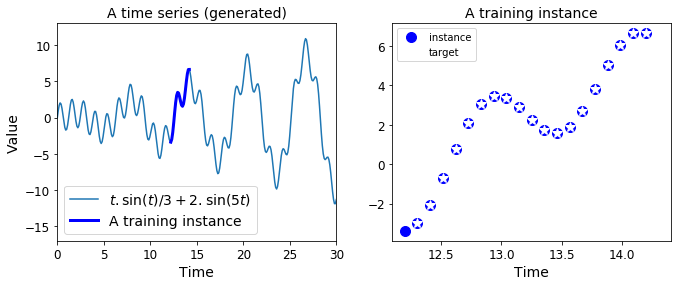

In [184]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


#save_fig("time_series_plot")
plt.show()

In [185]:
X_batch, y_batch = next_batch(1, n_steps)

In [186]:
np.c_[X_batch[0], y_batch[0]]

array([[ 6.95306855,  5.93946666],
       [ 5.93946666,  5.29242595],
       [ 5.29242595,  5.05659096],
       [ 5.05659096,  5.1579337 ],
       [ 5.1579337 ,  5.42307491],
       [ 5.42307491,  5.62310827],
       [ 5.62310827,  5.53118552],
       [ 5.53118552,  4.97974894],
       [ 4.97974894,  3.90338279],
       [ 3.90338279,  2.35677463],
       [ 2.35677463,  0.50336997],
       [ 0.50336997, -1.42252179],
       [-1.42252179, -3.1709135 ],
       [-3.1709135 , -4.53512855],
       [-4.53512855, -5.4001711 ],
       [-5.4001711 , -5.76865807],
       [-5.76865807, -5.75798641],
       [-5.75798641, -5.56945148],
       [-5.56945148, -5.43689959],
       [-5.43689959, -5.56750769]])

In [187]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [188]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [189]:
outputs

<tf.Tensor 'rnn/transpose_1:0' shape=(?, 20, 1) dtype=float32>

In [190]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [191]:
n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
            
    saver.save(sess, "./my_time_series_model") # not shown in the book

0 	MSE: 11.234554
100 	MSE: 0.38021225
200 	MSE: 0.12146816
300 	MSE: 0.064499006
400 	MSE: 0.05867635
500 	MSE: 0.056278024
600 	MSE: 0.050366167
700 	MSE: 0.045644782
800 	MSE: 0.0487576
900 	MSE: 0.046514533


TypeError: Cannot interpret feed_dict key as Tensor: The name 'save/Const:0' refers to a Tensor which does not exist. The operation, 'save/Const', does not exist in the graph.

In [193]:
with tf.Session() as sess:                          # not shown in the book
   saver.restore(sess, "./my_time_series_model")   # not shown

   X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
   y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


TypeError: Cannot interpret feed_dict key as Tensor: The name 'save/Const:0' refers to a Tensor which does not exist. The operation, 'save/Const', does not exist in the graph.

## Without using an OutputProjectionWrapper

In [132]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [133]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [134]:
n_outputs = 1
learning_rate = 0.001

In [135]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [136]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [137]:
n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

0 	MSE: 13.798524
100 	MSE: 0.51844853
200 	MSE: 0.18239002
300 	MSE: 0.0843517
400 	MSE: 0.06266621
500 	MSE: 0.06056202
600 	MSE: 0.05575837
700 	MSE: 0.05029873
800 	MSE: 0.051944032
900 	MSE: 0.048807137


In [138]:
y_pred

array([[[-3.449732 ],
        [-2.5135603],
        [-1.2743714],
        [ 0.557312 ],
        [ 2.0510874],
        [ 3.1630242],
        [ 3.6088107],
        [ 3.3626215],
        [ 2.8727925],
        [ 2.256619 ],
        [ 1.6973648],
        [ 1.4793212],
        [ 1.8544657],
        [ 2.7650523],
        [ 3.8564126],
        [ 5.0767837],
        [ 6.1231422],
        [ 6.688531 ],
        [ 6.695294 ],
        [ 6.112892 ]]], dtype=float32)

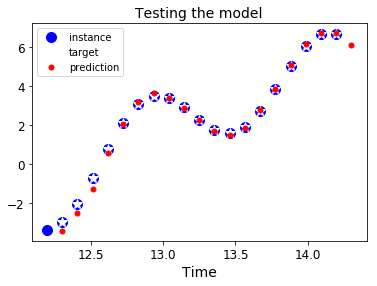

In [139]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Creative RNN

In [194]:
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./my_time_series_model") # not shown

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


TypeError: Cannot interpret feed_dict key as Tensor: The name 'save/Const:0' refers to a Tensor which does not exist. The operation, 'save/Const', does not exist in the graph.

# Deep RNN

## Multi RNN Cell

In [142]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [145]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

ValueError: Variable rnn/multi_rnn_cell/cell_0/basic_rnn_cell/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 3271, in create_op
    op_def=op_def)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)


In [146]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

In [147]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [148]:
keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [149]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [150]:
n_iterations = 1500
batch_size = 50
train_keep_prob = 0.5

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss],
                          feed_dict={X: X_batch, y: y_batch,
                                     keep_prob: train_keep_prob})
        if iteration % 100 == 0:                   # not shown in the book
            print(iteration, "Training MSE:", mse) # not shown

0 Training MSE: 14.682751
100 Training MSE: 6.7169037
200 Training MSE: 5.459441
300 Training MSE: 4.257571
400 Training MSE: 4.2164516
500 Training MSE: 3.3731182
600 Training MSE: 4.7782464
700 Training MSE: 4.5984983
800 Training MSE: 4.6204042
900 Training MSE: 3.7647784
1000 Training MSE: 3.9128013
1100 Training MSE: 3.9250882
1200 Training MSE: 3.4433184
1300 Training MSE: 3.6113741
1400 Training MSE: 4.2679553


In [151]:
with tf.Session() as sess:
    #saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

FailedPreconditionError: Attempting to use uninitialized value rnn/multi_rnn_cell/cell_0/basic_rnn_cell/bias
	 [[Node: rnn/multi_rnn_cell/cell_0/basic_rnn_cell/bias/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](rnn/multi_rnn_cell/cell_0/basic_rnn_cell/bias)]]

Caused by op 'rnn/multi_rnn_cell/cell_0/basic_rnn_cell/bias/read', defined at:
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-148-817a6a0f7419>", line 7, in <module>
    rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\rnn.py", line 632, in dynamic_rnn
    dtype=dtype)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\rnn.py", line 829, in _dynamic_rnn_loop
    swap_memory=swap_memory)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3096, in while_loop
    result = loop_context.BuildLoop(cond, body, loop_vars, shape_invariants)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2874, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2814, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3075, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\rnn.py", line 800, in _time_step
    (output, new_state) = call_cell()
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\rnn.py", line 786, in <lambda>
    call_cell = lambda: cell(input_t, state)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 190, in __call__
    return super(RNNCell, self).__call__(inputs, state)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\layers\base.py", line 696, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 1234, in call
    cur_inp, new_state = cell(cur_inp, cur_state)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 1056, in __call__
    output, new_state = self._cell(inputs, state, scope=scope)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 296, in __call__
    *args, **kwargs)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\layers\base.py", line 680, in __call__
    self.build(input_shapes)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 343, in build
    initializer=init_ops.zeros_initializer(dtype=self.dtype))
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\layers\base.py", line 533, in add_variable
    partitioner=partitioner)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1297, in get_variable
    constraint=constraint)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1093, in get_variable
    constraint=constraint)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 431, in get_variable
    return custom_getter(**custom_getter_kwargs)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 193, in _rnn_get_variable
    variable = getter(*args, **kwargs)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 408, in _true_getter
    use_resource=use_resource, constraint=constraint)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 800, in _get_single_variable
    use_resource=use_resource)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2157, in variable
    use_resource=use_resource)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2147, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2130, in default_variable_creator
    constraint=constraint)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\variables.py", line 233, in __init__
    constraint=constraint)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\variables.py", line 378, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\array_ops.py", line 131, in identity
    return gen_array_ops.identity(input, name=name)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 2656, in identity
    "Identity", input=input, name=name)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 3271, in create_op
    op_def=op_def)
  File "c:\users\zhuowu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value rnn/multi_rnn_cell/cell_0/basic_rnn_cell/bias
	 [[Node: rnn/multi_rnn_cell/cell_0/basic_rnn_cell/bias/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](rnn/multi_rnn_cell/cell_0/basic_rnn_cell/bias)]]


# LSTM

In [152]:
reset_graph()

lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

In [153]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [154]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>))

In [155]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>

In [156]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.9533333 Test accuracy = 0.9552
Epoch 1 Train accuracy = 0.9533333 Test accuracy = 0.9728
Epoch 2 Train accuracy = 0.98 Test accuracy = 0.9752
Epoch 3 Train accuracy = 0.99333334 Test accuracy = 0.9832
Epoch 4 Train accuracy = 0.99333334 Test accuracy = 0.9833
Epoch 5 Train accuracy = 0.9866667 Test accuracy = 0.9852
Epoch 6 Train accuracy = 1.0 Test accuracy = 0.9836
Epoch 7 Train accuracy = 1.0 Test accuracy = 0.9844
Epoch 8 Train accuracy = 0.99333334 Test accuracy = 0.9865
Epoch 9 Train accuracy = 1.0 Test accuracy = 0.9873


In [157]:
lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)

In [158]:
gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)

# Embeddings

## Fetch the data

In [159]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist.
    
    This is for python 2 support. In python >=3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [161]:
words = fetch_words_data()

In [162]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

## Build the dictionary

In [163]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [164]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5234, 3081,   12,    6,  195,    2, 3134,   46,   59]))

In [165]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'cycles originated as a term of abuse first used'

In [166]:
words[24], data[24]

('culottes', 0)

## Generate batches

In [167]:
import random
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [168]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [169]:
batch, [vocabulary[word] for word in batch]

(array([3081, 3081,   12,   12,    6,    6,  195,  195]),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [170]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[5234],
        [  12],
        [3081],
        [   6],
        [ 195],
        [  12],
        [   6],
        [   2]]),
 ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'a', 'of'])

## Build the model

In [171]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [172]:
reset_graph()

# Input data.
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [173]:
vocabulary_size = 50000
embedding_size = 150

# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [174]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [176]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

## Train the model

In [177]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  250.01710510253906
Nearest to would: viewpoint, lured, rossini, vara, teflon, glaciation, losing, eurasia,
Nearest to on: thatched, falsely, wi, vinegar, euskal, consequentialist, baroness, tallinn,
Nearest to four: hom, rez, siege, translators, khalil, pegged, hellene, ynys,
Nearest to his: pointers, ponty, charged, achieved, rk, blooming, value, juggernaut,
Nearest to often: presses, convenience, arabidopsis, jewry, mapuche, guts, macrinus, implemented,
Nearest to in: furnishing, qi, renderer, tuning, mckenna, illustrate, parser, advances,
Nearest to an: gutierrez, dyess, privations, archaeological, bijection, kon, joh, insemination,
Nearest to eight: malacca, liquidation, davidic, comical, ochre, wild, redman, unconditional,
Nearest to these: pedro, condoned, neck, ssn, supervising, doug, thereto, melton,
Nearest to nine: cocker, struck, dame, tensile, unifies, operetta, develop, opinions,
Nearest to called: paradoxes, wings, krantz, consults,

## Plot the embeddings

In [178]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

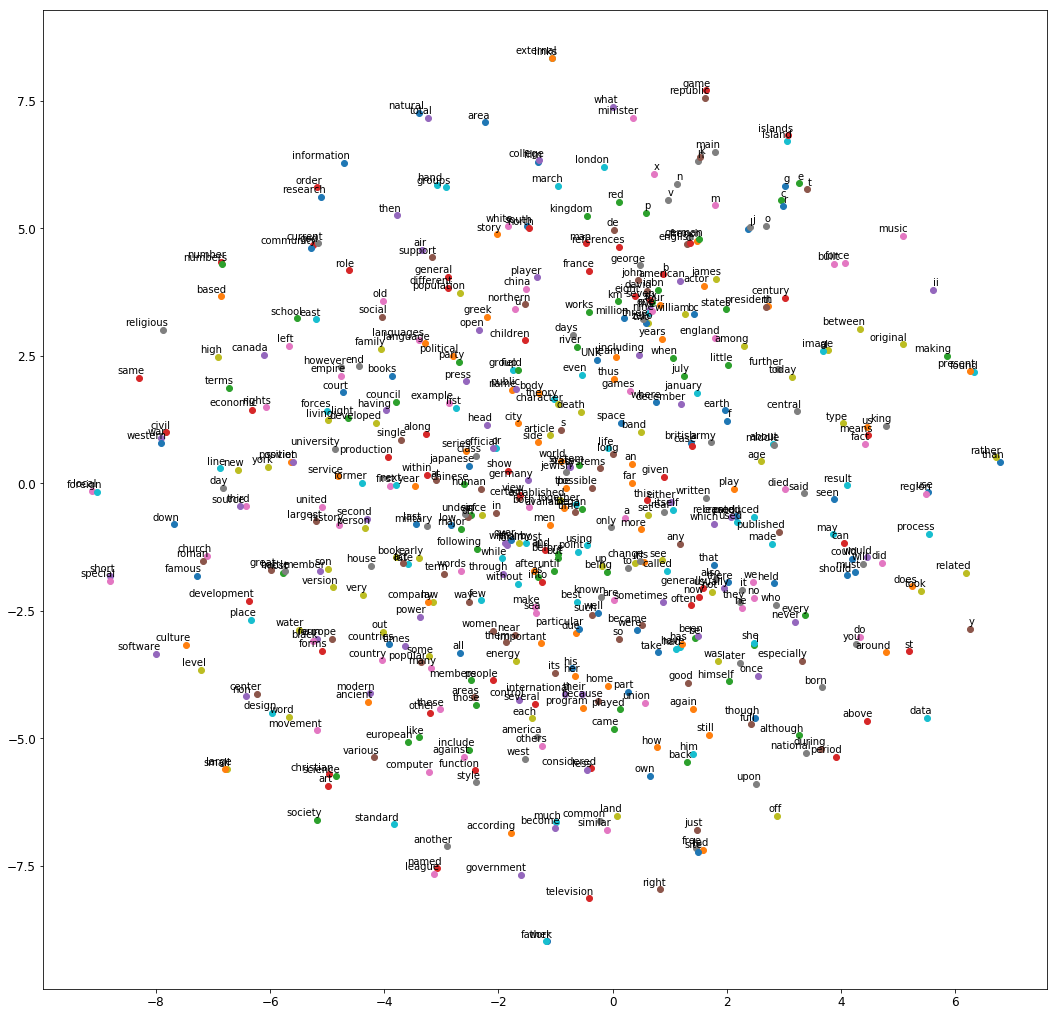

In [179]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

## Machine Translation

In [180]:
import tensorflow as tf
reset_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # English sentences
Y = tf.placeholder(tf.int32, [None, n_steps]) # French translations
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unstack(tf.transpose(X)) # list of 1D tensors
decoder_inputs = tf.unstack(tf.transpose(Y_input)) # list of 1D tensors

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

output_seqs, states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.unstack(output_seqs), perm=[1, 0, 2])

In [181]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_target_flat, logits=logits_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()